In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

import tensorflow as tf
from tensorflow import keras
from keras import layers, Input, Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
# Make False to disable screen logs 
printLogs = True


def output(text):
    if printLogs:
        print("-"*50)
        print(text)
        print("-"*50)

In [3]:
# mainDir is the main directory of the dataset

mainDir = "./pneumonia_xray_dataset"

trainDir = os.path.join(mainDir, "train")
testDir = os.path.join(mainDir, "test")
valDir = os.path.join(mainDir, "val")

output(f"Main Dir: \t{mainDir}\nTraining Dir: \t{trainDir}\nTesting Dir: \t{testDir}\nValidation Dir: {valDir}")

--------------------------------------------------
Main Dir: 	./pneumonia_xray_dataset
Training Dir: 	./pneumonia_xray_dataset\train
Testing Dir: 	./pneumonia_xray_dataset\test
Validation Dir: ./pneumonia_xray_dataset\val
--------------------------------------------------


# Data Preprocessing


In [52]:
# You can apply different "Data Augmentation" methods if needed.

train_datagen = ImageDataGenerator(
    rescale= 1./255,
    # rotation_range= 20,
    # width_shift_range= 0.2,
    # height_shift_range= 0.2,
    # zoom_range= 0.2,
    horizontal_flip= True,
)

test_datagen = ImageDataGenerator(
    rescale= 1./255
)

val_datagen = ImageDataGenerator(
    rescale= 1./255
)

In [53]:
image_size = (300, 400)
batch_size = 16



train_dataset = train_datagen.flow_from_directory(
    directory= trainDir,
    target_size= image_size,
    color_mode= "grayscale",
    batch_size= batch_size,
    class_mode= "sparse",
    shuffle= True,
    seed= 42,
    interpolation= "lanczos",
    
)

test_dataset = test_datagen.flow_from_directory(
    directory= testDir,
    target_size= image_size,
    color_mode= "grayscale",
    batch_size= batch_size,
    class_mode= "sparse",
    shuffle= False,
    interpolation= "lanczos",

)

val_dataset = val_datagen.flow_from_directory(
    directory= valDir,
    target_size= image_size,
    color_mode= "grayscale",
    batch_size= batch_size,
    class_mode= "sparse",
    shuffle= True,
    seed= 42,
    interpolation= "lanczos",

)

Found 9200 images belonging to 2 classes.
Found 468 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# Model Architecture

In [7]:
model = Sequential([
    Input(shape= train_dataset.image_shape, batch_size= batch_size),
    
    Conv2D(filters= 32, kernel_size= 3, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 64, kernel_size= 3, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 128, kernel_size= 5, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 256, kernel_size= 7, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Conv2D(filters= 512, kernel_size= 9, activation= "relu"),
    MaxPool2D(pool_size= 2, strides= 2),
    
    Flatten(),
    Dense(512, activation= "relu"),

    Dense(2, activation= "softmax")
    
    
    
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (16, 298, 398, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 149, 199, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 147, 197, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 73, 98, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 69, 94, 128)         204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (16, 34, 47, 128)        0

In [8]:
model.compile(
    optimizer=  keras.optimizers.Adam(),
    loss=       keras.losses.SparseCategoricalCrossentropy(),
    metrics=    ["accuracy"]
)

output(f"Optimizer: \t{model.optimizer.name}\nLoss Function: \t{model.loss.name}")

--------------------------------------------------
Optimizer: 	Adam
Loss Function: 	sparse_categorical_crossentropy
--------------------------------------------------


In [4]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

# Instantiate the VGG19 model
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new Sequential model
model2 = Sequential()

# Add VGG19 as a layer to the new model
model2.add(vgg19_model)

# Flatten the output from VGG19
model2.add(Flatten())

# Add a custom dense layer for classification
model2.add(Dense(512, activation='relu'))

# Output layer for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust the learning rate as needed
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    metrics=['accuracy']
)

# Print a summary of the model
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 32,870,465
Trainable params: 32,870,465
Non-trainable params: 0
_________________________________________________________________


# Training


In [8]:
epochs = 5  # Decreased the number of epochs
batch_size = 16  # Decreased the batch size

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0.3,  # Increased min_delta
    patience=2,  # Reduced patience
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop]
)


Epoch 1/5
575/575 [==============================] - 2976s 5s/step - loss: 0.4824 - accuracy: 0.7508 - val_loss: 0.4182 - val_accuracy: 0.8750
Epoch 2/5
575/575 [==============================] - 2039s 4s/step - loss: 0.1581 - accuracy: 0.9424 - val_loss: 0.2040 - val_accuracy: 0.9250
Epoch 3/5
575/575 [==============================] - 2461s 4s/step - loss: 0.1282 - accuracy: 0.9532 - val_loss: 0.2591 - val_accuracy: 0.9000
Epoch 3: early stopping


# Image Preprocessing for VGG19

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data generators for preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Rescale pixel values to the range [0, 1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

image_size = (224, 224)  # Adjust the image size to match VGG19 input requirements
batch_size = 16

# Train dataset
train_dataset2 = datagen.flow_from_directory(
    directory= trainDir,  # Replace with your training data directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # Adjust class mode if needed
    shuffle=True,
    seed=42,
)

# Test dataset
test_dataset2 = datagen.flow_from_directory(
    directory= testDir,  # Replace with your test data directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # Adjust class mode if needed
    shuffle=False,
)

# Validation dataset
val_dataset2 = datagen.flow_from_directory(
    directory=valDir,  # Replace with your validation data directory
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',  # Adjust class mode if needed
    shuffle=True,
    seed=42,
)


Found 9200 images belonging to 2 classes.
Found 468 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [1]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 5  # Adjust the number of epochs as needed
batch_size = 16

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights
)

# Train the VGG19 model with early stopping
history2 = model2.fit(
    train_dataset2,
    validation_data=val_dataset2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]  # Pass the early stopping callback
)


NameError: name 'model2' is not defined

# Visualize parameters of Model

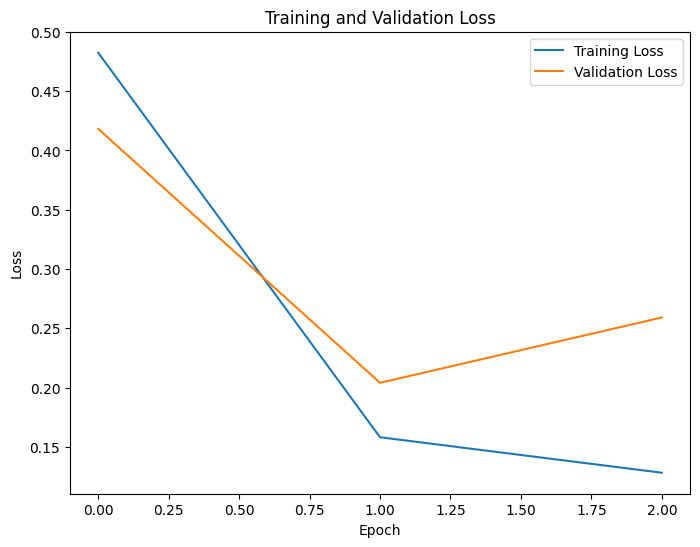

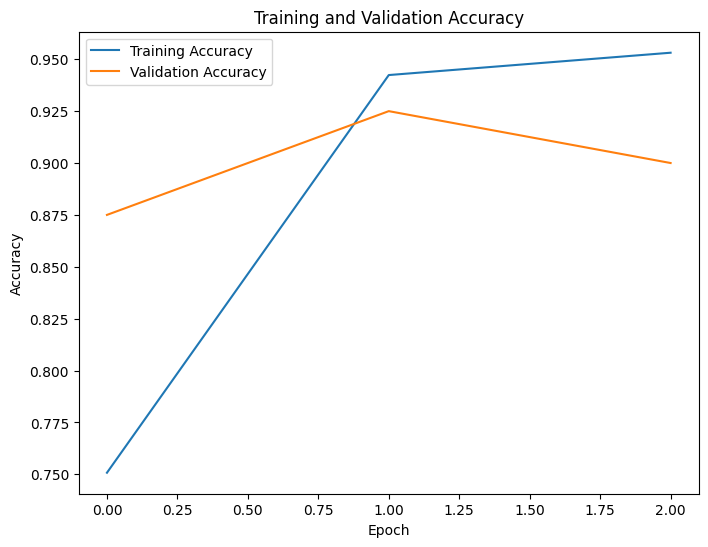

In [9]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Save the Model

In [13]:
model_file = "model-1"
# keras.models.save_model(model, model_file)

model.save(model_file)

INFO:tensorflow:Assets written to: model-1\assets


INFO:tensorflow:Assets written to: model-1\assets


# Load the model

In [14]:
model = keras.models.load_model(model_file)

# Check the performance on Training data

In [15]:
train_loss, train_accuracy = model.evaluate(train_dataset)

output(f"Train loss: \t{round(train_loss, 2)}\nTrain Accuracy: {round(train_accuracy, 2)}")

575/575 [==============================] - 1942s 3s/step - loss: 0.2045 - accuracy: 0.9164
--------------------------------------------------
Train loss: 	0.2
Train Accuracy: 0.92
--------------------------------------------------


# Check the performance on Test data

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset)


output(f"Test loss: \t{round(test_loss, 2)}\nTest Accuracy: \t{round(test_accuracy, 2)}")

30/30 [==============================] - 90s 3s/step - loss: 0.6247 - accuracy: 0.7201
--------------------------------------------------
Test loss: 	0.62
Test Accuracy: 	0.72
--------------------------------------------------


# Check the performance on Validation data

In [17]:
val_loss, val_accuracy = model.evaluate(train_dataset)


output(f"Validation loss: \t{round(val_loss, 2)}\nValidation Accuracy: \t{round(val_accuracy, 2)}")

575/575 [==============================] - 1793s 3s/step - loss: 0.2027 - accuracy: 0.9171
--------------------------------------------------
Validation loss: 	0.2
Validation Accuracy: 	0.92
--------------------------------------------------


# Visualize Testing performance

In [18]:
x = np.arange(len(test_dataset.classes))
y_real = test_dataset.classes
y_pred = np.argmax(model.predict(test_dataset), axis=1)

30/30 [==============================] - 88s 3s/step


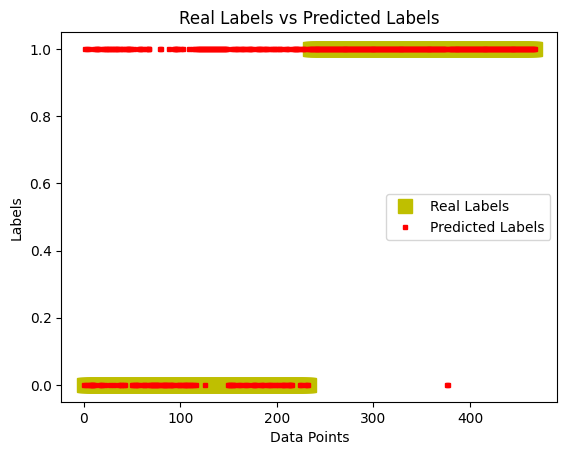

In [19]:
plt.plot(x, y_real, "ys", label= "Real Labels", markersize=10)
plt.plot(x, y_pred, "rs", label= "Predicted Labels", markersize=3)
plt.legend()

plt.xlabel("Data Points")
plt.ylabel("Labels")
plt.title("Real Labels vs Predicted Labels")
plt.show()

# Building a Confusion Matrix

In [20]:
cm = confusion_matrix(y_real, y_pred)
output(cm)

--------------------------------------------------
[[105 129]
 [  2 232]]
--------------------------------------------------


# Visualize a Confusion Matrix

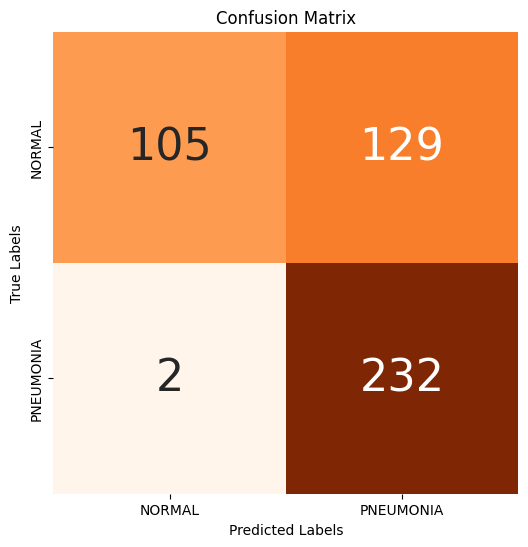

In [21]:
class_names = ["NORMAL", "PNEUMONIA"]
fontsize = 32

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size":fontsize})

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Visualize VGG19

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history2['loss'], label='Training Loss')
plt.plot(history.history2['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history2['accuracy'], label='Training Accuracy')
plt.plot(history.history2['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Check the performance on Training data

In [ ]:
train_loss, train_accuracy = model2.evaluate(train_dataset)

output(f"Train loss: \t{round(train_loss, 2)}\nTrain Accuracy: {round(train_accuracy, 2)}")

# Check the performance on Test data

In [ ]:
test_loss, test_accuracy = model2.evaluate(test_dataset)


output(f"Test loss: \t{round(test_loss, 2)}\nTest Accuracy: \t{round(test_accuracy, 2)}")

# Check the performance on Validation data

In [ ]:
val_loss, val_accuracy = model2.evaluate(train_dataset)


output(f"Validation loss: \t{round(val_loss, 2)}\nValidation Accuracy: \t{round(val_accuracy, 2)}")

# Building a Confusion Matrix¶

In [ ]:
x = np.arange(len(test_dataset.classes))
y_real = test_dataset.classes
y_pred = np.argmax(model2.predict(test_dataset), axis=1)

In [ ]:
cm = confusion_matrix(y_real, y_pred)
class_names = ["NORMAL", "PNEUMONIA"]
fontsize = 32

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size":fontsize})

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()